# 1. Load Paramter From Config File

In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))
print("Loaded project root:", PROJECT_ROOT)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from src.dataset import DeepPHQDataset, build_vocab, create_balanced_dataloader, split_by_pid
from models.lstm.lstm_model import DeepPHQLSTM 
from collections import defaultdict

import yaml

Loaded project root: /Users/yaochengyuan/Desktop/Study/CS 7643/DeepPHQ-main


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yaochengyuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load config
CONFIG_PATH = Path("lstm_config.yaml") 

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

config

{'data': {'level': 'word',
  'data_root': '../../data/processed',
  'word_csv': 'word_level.csv',
  'sentence_csv': 'sentence_level.csv',
  'dialogue_csv': 'dialogue_level.csv',
  'max_length': 512},
 'vocab': {'min_freq': 1, 'pad_token': '<PAD>', 'unk_token': '<UNK>'},
 'dataloader': {'batch_size': 16, 'num_workers': 2},
 'model': {'hidden_dim': 128,
  'num_layers': 2,
  'dropout': 0.1,
  'output_size': 1},
 'training': {'num_epochs': 10,
  'learning_rate': '3e-4',
  'weight_decay': '1e-5',
  'gradient_clip': 1.0,
  'seed': 2025},
 'checkpoint': {'save_dir': '../../models/checkpoints',
  'filename': 'deepphq_lstm.pt'}}

## 1.1 Set Seed

In [3]:
import random

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = config.get("training", {}).get("seed", 42)
set_seed(seed)
print(f"Seed set to {seed}")

Seed set to 2025


# 2. Load processed CSV data

In [4]:
data_cfg = config["data"]
root = Path(data_cfg["data_root"])

level = data_cfg["level"]

if level == "word":
    csv_path = root / data_cfg["word_csv"]
elif level == "sentence":
    csv_path = root / data_cfg["sentence_csv"]
elif level == "dialogue":
    csv_path = root / data_cfg["dialogue_csv"]
else:
    raise ValueError("Unknown level in config")

print("Loading:", csv_path)

df = pd.read_csv(csv_path)
df.head()

Loading: ../../data/processed/word_level.csv


,PID,Text,PHQ_Score
0,300,i sun the sure my my family two about you with...,2
1,300,who uh was and and in be georgia plan uh wante...,2
2,300,frustrated i enjoy minute college you here don...,2
3,300,shut i advice different friendship chocolate u...,2
4,300,career by took it was minute tall i i'm off um...,2


# 3. Build Vocab and Balanced DataLoader

In [5]:
all_texts = df["Text"].tolist()
vocab = build_vocab(all_texts, min_freq=config["vocab"]["min_freq"])

Vocab size = 8266


In [6]:
# 1. split
train_df, val_df, test_df = split_by_pid(df)

# 2. create datasets
train_dataset = DeepPHQDataset(
    data=list(zip(train_df["PID"], train_df["Text"], train_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

val_dataset = DeepPHQDataset(
    data=list(zip(val_df["PID"], val_df["Text"], val_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

test_dataset = DeepPHQDataset(
    data=list(zip(test_df["PID"], test_df["Text"], test_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

# 3. dataloaders
train_loader = create_balanced_dataloader(
    train_dataset,
    batch_size=config["dataloader"]["batch_size"]
)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. verify shapes
batch = next(iter(train_loader))
print(batch["input_ids"].shape)
print(batch["label"].shape)
print(batch["pid"].shape)

torch.Size([16, 512])
torch.Size([16])
torch.Size([16])


# 4. Init LSTM Model

In [7]:
# ---- Load model config ----
model_cfg = config["model"]

# ---- Auto-select device ----
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using device:", device)

# ---- Init model ----
model = DeepPHQLSTM(
    input_size=len(vocab),
    output_size=model_cfg["output_size"],
    hidden_dim=model_cfg["hidden_dim"],
    num_layers=model_cfg["num_layers"],
    dropout=model_cfg["dropout"]
).to(device)

Using device: mps


# 5. Train and Evaluate the Model

In [8]:
train_cfg = config["training"]

optimizer = AdamW(
    model.parameters(),
    lr=float(train_cfg["learning_rate"]),
    weight_decay=float(train_cfg["weight_decay"])
)
train_losses = []
val_losses = []
criterion = nn.MSELoss()

for epoch in range(train_cfg["num_epochs"]):
    model.train()
    epoch_loss = 0

    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in progress:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids).squeeze()

        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), train_cfg["gradient_clip"])
        optimizer.step()

        epoch_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- compute validation loss ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")
    print("Training finished for level:", config["data"]["level"])

Epoch 1: 100%|█████████████████████| 164/164 [00:14<00:00, 11.43it/s, loss=43.8]


Epoch 1 | Train Loss = 54.2053 | Val Loss = 46.7567
Training finished for level: word


Epoch 2: 100%|█████████████████████| 164/164 [00:13<00:00, 12.01it/s, loss=26.7]


Epoch 2 | Train Loss = 29.1520 | Val Loss = 41.9803
Training finished for level: word


Epoch 3: 100%|█████████████████████| 164/164 [00:13<00:00, 12.04it/s, loss=7.99]


Epoch 3 | Train Loss = 15.2660 | Val Loss = 48.8688
Training finished for level: word


Epoch 4: 100%|█████████████████████| 164/164 [00:13<00:00, 12.50it/s, loss=8.74]


Epoch 4 | Train Loss = 8.5977 | Val Loss = 46.7923
Training finished for level: word


Epoch 5: 100%|█████████████████████| 164/164 [00:13<00:00, 11.97it/s, loss=6.52]


Epoch 5 | Train Loss = 5.7140 | Val Loss = 46.8708
Training finished for level: word


Epoch 6: 100%|█████████████████████| 164/164 [00:14<00:00, 11.64it/s, loss=2.46]


Epoch 6 | Train Loss = 4.2468 | Val Loss = 45.1619
Training finished for level: word


Epoch 7: 100%|█████████████████████| 164/164 [00:16<00:00,  9.76it/s, loss=3.62]


Epoch 7 | Train Loss = 3.5610 | Val Loss = 40.7369
Training finished for level: word


Epoch 8: 100%|██████████████████████| 164/164 [00:13<00:00, 11.87it/s, loss=1.6]


Epoch 8 | Train Loss = 2.5927 | Val Loss = 44.2429
Training finished for level: word


Epoch 9: 100%|█████████████████████| 164/164 [00:14<00:00, 11.14it/s, loss=2.06]


Epoch 9 | Train Loss = 2.0810 | Val Loss = 37.8672
Training finished for level: word


Epoch 10: 100%|████████████████████| 164/164 [00:13<00:00, 12.02it/s, loss=3.92]


Epoch 10 | Train Loss = 1.8389 | Val Loss = 44.8471
Training finished for level: word


In [9]:
model.eval()

pid_to_preds = defaultdict(list)
pid_to_labels = {}

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].float().to(device)
        pids = batch["pid"].tolist()

        preds = model(input_ids).squeeze(-1)  # (batch,)

        for pid, pred, true_label in zip(pids,
                                         preds.cpu().numpy(),
                                         labels.cpu().numpy()):
            pid_to_preds[pid].append(float(pred))
            pid_to_labels[pid] = float(true_label)  # same for all entries of this pid

sq_errors = []
for pid in pid_to_preds:
    pred_pid = np.mean(pid_to_preds[pid])
    true_pid = pid_to_labels[pid]
    sq_errors.append((pred_pid - true_pid) ** 2)

pid_mse = float(np.mean(sq_errors))

print("Test PID-level MSE:", pid_mse)

Test PID-level MSE: 35.2570292444704


In [10]:
level = config["data"]["level"]

if level == "dialogue":
    dialogue_train_losses = train_losses.copy()
    dialogue_val_losses = val_losses.copy()
    pid_mse_dialogue = pid_mse
    print("Saved dialogue-level losses.")

elif level == "sentence":
    sentence_train_losses = train_losses.copy()
    sentence_val_losses = val_losses.copy()
    pid_mse_sentence = pid_mse
    print("Saved sentence-level losses.")
    

elif level == "word":
    word_train_losses = train_losses.copy()
    word_val_losses = val_losses.copy()
    pid_mse_word = pid_mse
    print("Saved word-level losses.")
    
else:
    print("Unknown level:", level)

Saved word-level losses.


# 6. Save Result as pt Format

In [11]:
save_dir = Path(config["checkpoint"]["save_dir"])
level = config["data"]["level"]   # "word", "sentence", "dialogue"

model_name = f"{level}.pt"
save_path = save_dir / model_name

save_dir.mkdir(parents=True, exist_ok=True)

torch.save({
    "model_state": model.state_dict(),
    "vocab": vocab,
    "config": config,
}, save_path)

print(f"[✓] Saved model to: {save_path}")

[✓] Saved model to: ../../models/checkpoints/word.pt


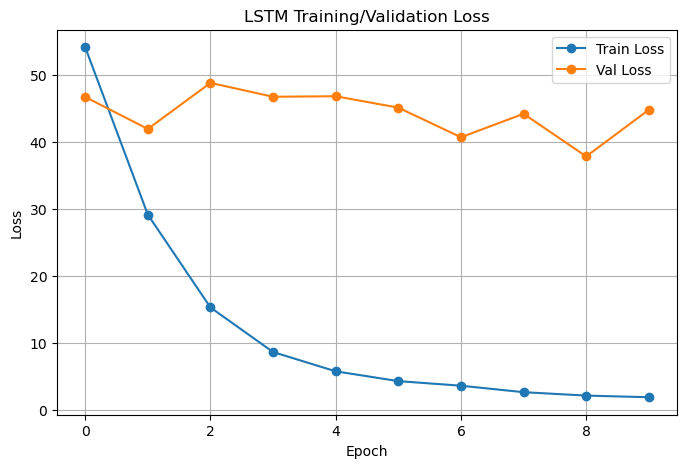

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Training/Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Note: before running the following 2 cells, run all cells above with gradularity set to dialogue, sentence and word repsectively without retarting the kernel.

In [13]:
import matplotlib.pyplot as plt

epochs_dialogue = range(1, len(dialogue_val_losses) + 1)
epochs_sentence = range(1, len(sentence_val_losses) + 1)
epochs_word = range(1, len(word_val_losses) + 1)

plt.figure(figsize=(8, 5))

plt.plot(epochs_dialogue, dialogue_val_losses, marker="o", label="Dialogue-level")
plt.plot(epochs_sentence, sentence_val_losses, marker="s", label="Sentence-level")
plt.plot(epochs_word, word_val_losses, marker="^", label="Word-level")

plt.xlabel("Epoch")
plt.ylabel("Validation MSE")
plt.title("LSTM Validation MSE Loss Over Different Input Granularities")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'dialogue_val_losses' is not defined

In [ ]:
import matplotlib.pyplot as plt

granularities = ["Dialogue", "Sentence", "Word"]
pid_mse = [pid_mse_dialogue,pid_mse_sentence, pid_mse_word] #calculated before

plt.figure(figsize=(6, 4))
bars = plt.bar(granularities, pid_mse)

for bar, value in zip(bars, pid_mse):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{value:.2f}",
        ha="center",
        va="bottom"
    )

plt.ylabel("PID-level MSE")
plt.title("LSTM PID-level MSE across input granularities")
plt.tight_layout()
plt.show()